In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from trading_env import ShortTermDynamicTrader, fetch_intraday, add_indicators
from actor_critic_agent import ActorCriticAgent

warnings.filterwarnings('ignore')


def train_agent():
    print("=" * 60)
    global env, agent

    print("Fetching trading data...")
    symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']

    try:
        data_dict = fetch_intraday(
            tickers=symbols,
            interval="5m",
            period="60d",
            min_rows=200
        )

        if not data_dict:
            print("Falling back to manual fetch...")
            data_dict = {}
            for ticker in symbols:
                try:
                    print(f"   Fetching {ticker}...")
                    df = yf.download(ticker, interval="5m", period="60d", progress=False, auto_adjust=False)
                    if df.empty:
                        print(f"   [SKIPPED] {ticker}: No data returned.")
                        continue
                    df = add_indicators(df)
                    if df.shape[0] < 100:
                        print(f"   [SKIPPED] {ticker}: Not enough rows after indicators ({df.shape[0]} rows).")
                        continue
                    data_dict[ticker] = df
                    print(f"    {ticker}: {len(df)} rows")
                except Exception as e:
                    print(f"   [ERROR] {ticker}: {e}")

            if data_dict:
                all_indices = [set(df.index) for df in data_dict.values()]
                common_index = sorted(list(set.intersection(*all_indices)))
                if len(common_index) < 100:
                    print("   Not enough common timestamps across tickers.")
                    data_dict = {}
                else:
                    common_index = common_index[-100:]
                    for k in data_dict:
                        data_dict[k] = data_dict[k].loc[common_index]
                    print(f"    Applied common index: {len(common_index)} timestamps")

            if not data_dict:
                print(" No valid data fetched. Returning empty dict.")
                return None, None

        print(f"Successfully fetched data for {len(data_dict)} assets")
        for ticker, df in data_dict.items():
            print(f"   {ticker}: {len(df)} rows, from {df.index[0]} to {df.index[-1]}")

    except Exception as e:
        print(f" Error fetching data: {e}")
        return None, None

    try:
        env = ShortTermDynamicTrader(
            data_dict=data_dict,
            window_size=5,
            initial_balance=100000,
            transaction_cost_pct=0.0001,
            slippage_pct=0.0005,
            max_alloc_per_asset=0.2,
            min_price_filter=1.0
        )

        print(f"   Observation space: {env.observation_space.shape}")
        print(f"   Action space: {env.action_space.shape}")
        print(f"   Assets: {env.asset_names}")
        print(f"   Window size: {env.window_size}")
        print(f"   Initial balance: ${env.initial_balance:,}")
        print(f"   Transaction cost: {env.transaction_cost_pct * 100:.1f}%")
        print(f"   Max allocation per asset: {env.max_alloc_per_asset * 100:.0f}%")

        min_data_length = min(len(df) for df in data_dict.values())
        available_episodes = min_data_length - env.window_size - 1
        print(f"   Available episodes: ~{available_episodes}")

    except Exception as e:
        print(f" Error creating environment: {e}")
        return None, None

    try:
        obs, info = env.reset()
        print(f"   Reset successful. Observation shape: {obs.shape}")

        test_action = np.random.uniform(-1, 1, size=len(env.asset_names))
        obs, reward, done, truncated, info = env.step(test_action)
        print(f"   Step successful. Reward: {reward:.6f}")
        print(f"   Info keys: {list(info.keys())}")
        if 'net_worth' in info:
            print(f"   Net worth properly accessible: ${info['net_worth']:.2f}")

    except Exception as e:
        print(f" Environment test failed: {e}")
        return None, None

    try:
        agent = ActorCriticAgent(
            env=env,
            gamma=0.99,
            tau=0.005,
            actor_lr=1e-4,
            critic_lr=3e-4,
            buffer_size=100000,
            batch_size=128,
            warm_up=5000
        )
    except Exception as e:
        print(f" Error initializing agent: {e}")
        return None, None

    print("-" * 60)

    try:
        print("=" * 60)
        net_worths, episode_returns = agent.train(episodes=200, print_every=10)
        return agent, (net_worths, episode_returns)

    except Exception as e:
        print(f" Training error: {e}")
        import traceback
        traceback.print_exc()
        return agent, None


if __name__ == "__main__":
    trained_agent, training_results = train_agent()

    if trained_agent is not None and training_results is not None:
        agent = trained_agent
        net_worths, episode_returns = training_results
        training_completed = True

        print(f"\n📊 FINAL TRAINING RESULTS:")
        print(f"   Final Net Worth: ${net_worths[-1]:,.2f}")
        print(f"   Total Return: {episode_returns[-1]:.2f}%")
        print(f"   Best Episode: ${max(net_worths):,.2f}")
        print(f"   Worst Episode: ${min(net_worths):,.2f}")
        print(f"   Episodes Completed: {len(net_worths)}")
        print(f"   Average Return: {np.mean(episode_returns):.2f}%")
        print(f"   Return Volatility: {np.std(episode_returns):.2f}%")

        positive_returns = sum(1 for r in episode_returns if r > 0)
        win_rate = positive_returns / len(episode_returns) * 100
        print(f"   Win Rate: {win_rate:.1f}% ({positive_returns}/{len(episode_returns)} episodes)")
    else:
        print(" Training failed.")
        training_completed = False

training_completed = training_completed if 'training_completed' in locals() else False


Fetching trading data...
Successfully fetched data for 5 assets
   AAPL: 200 rows, from 2025-07-17 16:10:00+00:00 to 2025-07-21 19:45:00+00:00
   GOOGL: 200 rows, from 2025-07-17 16:10:00+00:00 to 2025-07-21 19:45:00+00:00
   MSFT: 200 rows, from 2025-07-17 16:10:00+00:00 to 2025-07-21 19:45:00+00:00
   TSLA: 200 rows, from 2025-07-17 16:10:00+00:00 to 2025-07-21 19:45:00+00:00
   AMZN: 200 rows, from 2025-07-17 16:10:00+00:00 to 2025-07-21 19:45:00+00:00
   Observation space: (206,)
   Action space: (5,)
   Assets: ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
   Window size: 5
   Initial balance: $100,000
   Transaction cost: 0.0%
   Max allocation per asset: 20%
   Available episodes: ~194
   Reset successful. Observation shape: (206,)
   Step successful. Reward: -0.000195
   Info keys: ['net_worth', 'balance', 'positions', 'trades', 'net_worths']
   Net worth properly accessible: $99980.48
------------------------------------------------------------


Training: 100%|███████████████████████| 200/200 [27:36<00:00,  8.28s/it, Ep=200, Return=0.00%, Net=$100,003, Steps=110]


📊 FINAL TRAINING RESULTS:
   Final Net Worth: $100,002.59
   Total Return: 0.00%
   Best Episode: $102,483.26
   Worst Episode: $99,101.42
   Episodes Completed: 200
   Average Return: 0.17%
   Return Volatility: 0.66%
   Win Rate: 46.0% (92/200 episodes)


In [2]:


import os
import numpy as np
import pandas as pd
from datetime import datetime


def save_model(agent, filepath="actor_critic_agent"):
   
    try:
        # Save with proper .weights.h5 extension (fixes ValueError)
        agent.actor.save_weights(f"{filepath}_actor.weights.h5")
        agent.critic1.save_weights(f"{filepath}_critic1.weights.h5")
        agent.critic2.save_weights(f"{filepath}_critic2.weights.h5")
        agent.target_actor.save_weights(f"{filepath}_target_actor.weights.h5")
        agent.target_critic1.save_weights(f"{filepath}_target_critic1.weights.h5")
        agent.target_critic2.save_weights(f"{filepath}_target_critic2.weights.h5")

        
        metadata = {
            'state_size': agent.state_size,
            'action_size': agent.action_size,
            'gamma': agent.gamma,
            'tau': agent.tau,
            'batch_size': agent.batch_size,
            'warm_up': agent.warm_up,
            'buffer_size': len(agent.replay_buffer),
            'noise_sigma': agent.noise.sigma,
            'saved_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        import json
        with open(f"{filepath}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f" Model saved successfully to {filepath}")
        print(f"   Actor: {filepath}_actor.weights.h5")
        print(f"   Critics: {filepath}_critic1.weights.h5, {filepath}_critic2.weights.h5")
        print(f"   Targets: {filepath}_target_*.weights.h5")
        print(f"   Metadata: {filepath}_metadata.json")

    except Exception as e:
        print(f" Error saving model: {e}")

def load_model(agent, filepath="actor_critic_agent"):
    """Load the trained models from saved weights"""
    try:
        if not os.path.exists(f"{filepath}_actor.weights.h5"):
            print(f" Model files not found. Expected: {filepath}_actor.weights.h5")
            return False

       
        agent.actor.load_weights(f"{filepath}_actor.weights.h5")
        agent.critic1.load_weights(f"{filepath}_critic1.weights.h5")
        agent.critic2.load_weights(f"{filepath}_critic2.weights.h5")
        agent.target_actor.load_weights(f"{filepath}_target_actor.weights.h5")
        agent.target_critic1.load_weights(f"{filepath}_target_critic1.weights.h5")
        agent.target_critic2.load_weights(f"{filepath}_target_critic2.weights.h5")

       
        metadata_file = f"{filepath}_metadata.json"
        if os.path.exists(metadata_file):
            import json
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            print(f" Model loaded successfully!")
            print(f"   Saved: {metadata.get('saved_timestamp', 'Unknown')}")
            print(f"   Buffer size at save: {metadata.get('buffer_size', 'Unknown')}")
        else:
            print(f" Model weights loaded successfully!")

        return True

    except Exception as e:
        print(f" Error loading model: {e}")
        return False

def test_agent(agent, env, episodes=5, verbose=True):

    print(f"\n Testing trained agent for {episodes} episodes...")
    print("=" * 50)

    test_results = []

    for episode in range(episodes):
        state, info = env.reset()
        total_reward = 0
        episode_length = 0

        done = False
        while not done:
           
            action = agent.act(state, add_noise=False)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            state = next_state
            total_reward += reward
            episode_length += 1

            if done:
                break

        
        final_net_worth = info.get('net_worth', env.initial_balance)
        final_balance = info.get('balance', 0)
        portfolio_return = ((final_net_worth - env.initial_balance) / env.initial_balance) * 100
        num_trades = len(info.get('trades', []))

        test_results.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'final_net_worth': final_net_worth,
            'final_balance': final_balance,
            'portfolio_return': portfolio_return,
            'episode_length': episode_length,
            'num_trades': num_trades
        })

        if verbose:
            print(f"Test Episode {episode + 1}:")
            print(f"  Total Reward: {total_reward:.4f}")
            print(f"  Final Balance: ${final_balance:.2f}")
            print(f"  Final Net Worth: ${final_net_worth:.2f}")
            print(f"  Portfolio Return: {portfolio_return:.2f}%")
            print(f"  Episode Length: {episode_length} steps")
            print(f"  Number of Trades: {num_trades}")
            print("-" * 50)

    
    df_results = pd.DataFrame(test_results)
   
    print(f"  Average Return: {df_results['portfolio_return'].mean():.2f}%")
    print(f"  Return Std: {df_results['portfolio_return'].std():.2f}%")
    print(f"  Best Episode: {df_results['portfolio_return'].max():.2f}%")
    print(f"  Worst Episode: {df_results['portfolio_return'].min():.2f}%")
    print(f"  Win Rate: {(df_results['portfolio_return'] > 0).mean()*100:.1f}%")
    print(f"  Average Trades per Episode: {df_results['num_trades'].mean():.1f}")
    print("=" * 50)

    return test_results

def quick_evaluation(agent, env):
   
    print(" Quick evaluation...")

    state, info = env.reset()
    total_reward = 0
    step_count = 0

    done = False
    while not done and step_count < 50:  # Limit steps for quick eval
        action = agent.act(state, add_noise=False)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1

    
    final_net_worth = info.get('net_worth', env.initial_balance)
    portfolio_return = ((final_net_worth - env.initial_balance) / env.initial_balance) * 100

    print(f" Quick eval complete:")
    print(f"   Steps: {step_count}, Return: {portfolio_return:.2f}%")
    print(f"   Final Net Worth: ${final_net_worth:.2f}")

    return portfolio_return


def run_save_load_test():
   
    global agent, training_completed

    if not training_completed:
        print(" No trained agent found. Run the training cell first.")
        return

    # Save the model
    print(" Saving trained model...")
    save_model(agent, "fixed_trading_agent")

    # Test the agent
    print("\n Testing agent performance...")
    test_results = test_agent(agent, env, episodes=3, verbose=True)

    # Quick evaluation
    quick_return = quick_evaluation(agent, env)

    print(f"\n Save/Load/Test completed successfully!")
    print(f"   Model saved as: fixed_trading_agent_*.weights.h5")
    print(f"   Quick evaluation return: {quick_return:.2f}%")

    return test_results

# Run the save/load/test workflow
if 'training_completed' in globals() and training_completed:
    print("🚀 Running save/load/test workflow...")
    test_results = run_save_load_test()
else:
    print("  Training not completed yet. Run the training cell first.")
    print(" After training completes, run this cell to save and test your model.")


🚀 Running save/load/test workflow...
 Saving trained model...
 Model saved successfully to fixed_trading_agent
   Actor: fixed_trading_agent_actor.weights.h5
   Critics: fixed_trading_agent_critic1.weights.h5, fixed_trading_agent_critic2.weights.h5
   Targets: fixed_trading_agent_target_*.weights.h5
   Metadata: fixed_trading_agent_metadata.json

 Testing agent performance...

 Testing trained agent for 3 episodes...
Test Episode 1:
  Total Reward: -0.0023
  Final Balance: $1009.28
  Final Net Worth: $99773.82
  Portfolio Return: -0.23%
  Episode Length: 45 steps
  Number of Trades: 35
--------------------------------------------------
Test Episode 2:
  Total Reward: -0.0035
  Final Balance: $972.59
  Final Net Worth: $99650.85
  Portfolio Return: -0.35%
  Episode Length: 119 steps
  Number of Trades: 260
--------------------------------------------------
Test Episode 3:
  Total Reward: -0.0023
  Final Balance: $1009.28
  Final Net Worth: $99773.82
  Portfolio Return: -0.23%
  Episode 

TRAINING SUMMARY STATISTICS
Total Episodes: 200
Final Net Worth: $100,002.59
Total Return: 0.00%
Best Episode Net Worth: $102,483.26
Worst Episode Net Worth: $99,101.42
Average Return: 0.17%
Return Std: 0.66%


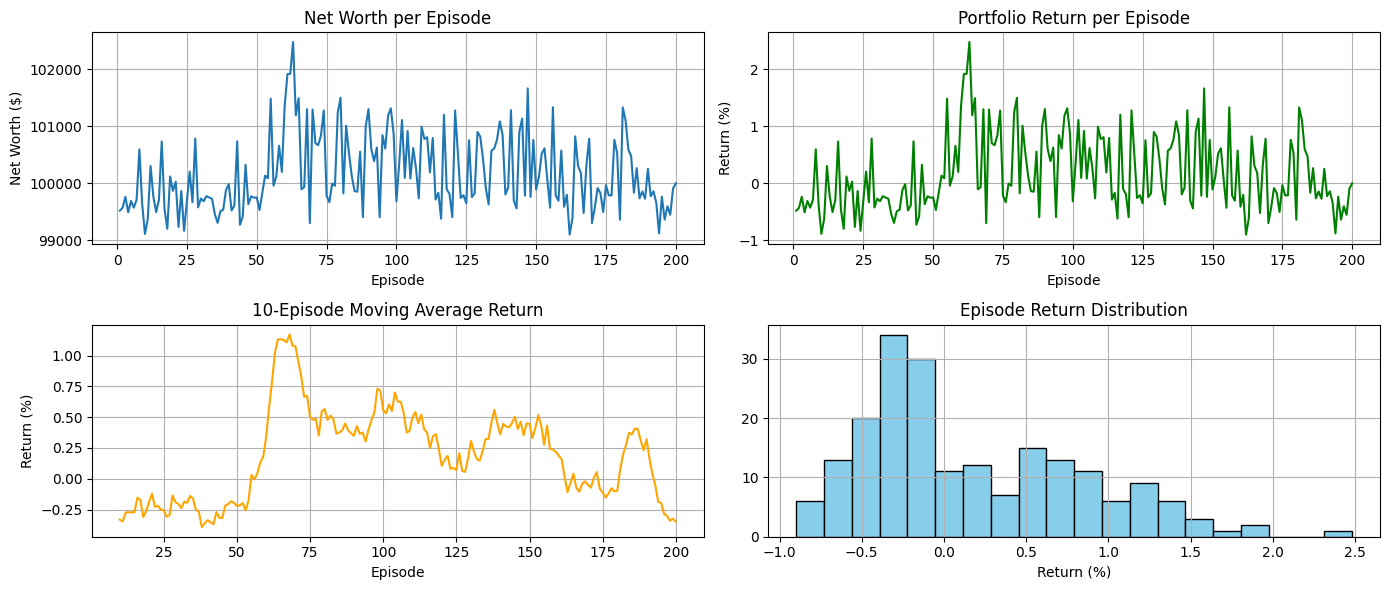

Win rate: 92/200 = 46.0%


In [3]:
# =============================================================================
# PLOTTING & ANALYSIS CELL – Use after training/testing
# =============================================================================

import matplotlib.pyplot as plt

def plot_training_results(net_worths, episode_returns, show_winrate=True):
    """Plots key agent statistics after training."""
    episodes = range(1, len(net_worths) + 1)
    plt.figure(figsize=(14,6))
    # Net worth
    plt.subplot(2,2,1)
    plt.plot(episodes, net_worths, label="Net Worth")
    plt.xlabel("Episode")
    plt.ylabel("Net Worth ($)")
    plt.title("Net Worth per Episode")
    plt.grid()
    # Episode returns
    plt.subplot(2,2,2)
    plt.plot(episodes, episode_returns, label="Episode Return (%)", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Return (%)")
    plt.title("Portfolio Return per Episode")
    plt.grid()
    # Running average returns
    plt.subplot(2,2,3)
    window = min(10, len(episode_returns))
    rolling_mean = pd.Series(episode_returns).rolling(window).mean()
    plt.plot(episodes, rolling_mean, label=f"{window}-ep Rolling Avg", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Return (%)")
    plt.title(f"{window}-Episode Moving Average Return")
    plt.grid()
    # Histogram of returns
    plt.subplot(2,2,4)
    plt.hist(episode_returns, bins=20, color="skyblue", edgecolor="black")
    plt.xlabel("Return (%)")
    plt.title("Episode Return Distribution")
    plt.grid()
    plt.tight_layout()
    plt.show()

    if show_winrate:
        wins = sum(r > 0 for r in episode_returns)
        print(f"Win rate: {wins}/{len(episode_returns)} = {100*wins/len(episode_returns):.1f}%")

def print_training_summary(net_worths, episode_returns):
    """Prints a textual summary of training performance."""
    print("="*60)
    print("TRAINING SUMMARY STATISTICS")
    print("="*60)
    print(f"Total Episodes: {len(net_worths)}")
    print(f"Final Net Worth: ${net_worths[-1]:,.2f}")
    print(f"Total Return: {episode_returns[-1]:.2f}%")
    print(f"Best Episode Net Worth: ${max(net_worths):,.2f}")
    print(f"Worst Episode Net Worth: ${min(net_worths):,.2f}")
    print(f"Average Return: {np.mean(episode_returns):.2f}%")
    print(f"Return Std: {np.std(episode_returns):.2f}%")
    print("="*60)

# Example usage after training:
if 'net_worths' in globals() and 'episode_returns' in globals():
    print_training_summary(net_worths, episode_returns)
    plot_training_results(net_worths, episode_returns)
else:
    print("Train agent before plotting.")
